In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime
from dateutil.parser import parse
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///C:/Users/dshaf/Documents/School/repository/GTATL201808DATA3/Homework/11-Adv-Data-Storage-Retrieval/Instructions/Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
meas_cols = inspector.get_columns('Measurement')
print('Columns in Measurement')
print('-------')
for item in meas_cols:
    print(item['name'])

Columns in Measurement
-------
id
station
date
prcp
tobs


In [11]:
engine.execute('SELECT * FROM Measurement LIMIT 3').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0)]

In [12]:
meas_cols = inspector.get_columns('Station')
print('Columns in Station')
print('-------')
for item in meas_cols:
    print(item['name'])

Columns in Station
-------
id
station
name
latitude
longitude
elevation


In [13]:
engine.execute('SELECT * FROM Station LIMIT 3').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)]

# Exploratory Climate Analysis

In [20]:
precip

[('2016-08-24', 'USC00519397', 0.08, 79.0),
 ('2016-08-25', 'USC00519397', 0.08, 80.0),
 ('2016-08-26', 'USC00519397', 0.0, 79.0),
 ('2016-08-27', 'USC00519397', 0.0, 77.0),
 ('2016-08-28', 'USC00519397', 0.01, 78.0),
 ('2016-08-29', 'USC00519397', 0.0, 78.0),
 ('2016-08-30', 'USC00519397', 0.0, 79.0),
 ('2016-08-31', 'USC00519397', 0.13, 80.0),
 ('2016-09-01', 'USC00519397', 0.0, 81.0),
 ('2016-09-02', 'USC00519397', 0.0, 80.0),
 ('2016-09-03', 'USC00519397', 0.0, 79.0),
 ('2016-09-04', 'USC00519397', 0.03, 75.0),
 ('2016-09-05', 'USC00519397', None, 79.0),
 ('2016-09-06', 'USC00519397', None, 76.0),
 ('2016-09-07', 'USC00519397', 0.05, 76.0),
 ('2016-09-08', 'USC00519397', 0.0, 80.0),
 ('2016-09-09', 'USC00519397', 0.03, 79.0),
 ('2016-09-10', 'USC00519397', 0.0, 78.0),
 ('2016-09-11', 'USC00519397', 0.05, 76.0),
 ('2016-09-12', 'USC00519397', 0.0, 78.0),
 ('2016-09-13', 'USC00519397', 0.02, 78.0),
 ('2016-09-14', 'USC00519397', 1.32, 75.0),
 ('2016-09-15', 'USC00519397', 0.42, 79.0)

<IPython.core.display.Javascript object>


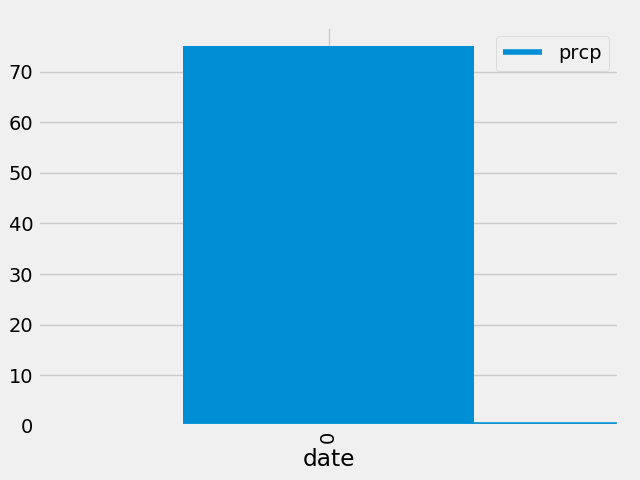

In [146]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today

max_date = session.query(func.max(Measurement.date)).all()[0][0]
max_date = datetime.strptime(max_date, '%Y-%m-%d')
year_a = dt.timedelta(days=365)
one_year_ago = max_date - year_a

# Perform a query to retrieve the data and precipitation scores

precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(precip, columns = ['date', 'prcp'])
# Sort the dataframe by date
df = df.set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot.line(rot=45)
plt.tight_layout()
# Rotate the xticks for the dates


In [63]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [103]:
# How many stations are available in this dataset?
unique_stations = session.query(Measurement).filter(Measurement.date > one_year_ago).group_by(Measurement.station).count()
unique_stations

7

In [121]:
# What are the most active stations?
active_stations = session.query(Measurement.station).filter(Measurement.date > one_year_ago).all()
active_stations = pd.DataFrame(active_stations, columns = ['station'])
active_stations['station'].value_counts()
# List the stations and the counts in descending order.


USC00519397    360
USC00519281    351
USC00516128    348
USC00513117    342
USC00519523    336
USC00514830    304
USC00517948    182
Name: station, dtype: int64

In [135]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [Measurement.station,
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)]
stats = session.query(*sel).filter(Measurement.date > one_year_ago)\
                                            .filter(Measurement.station == 'USC00519397').all()
stats

[('USC00519397', 60.0, 87.0, 75.19444444444444)]

<IPython.core.display.Javascript object>


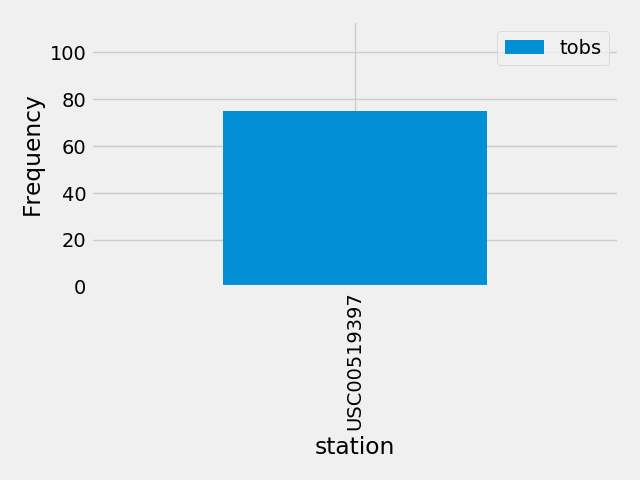

In [129]:
# Choose the station with the highest number of temperature observations.
temp = session.query(Measurement.tobs).filter(Measurement.date > one_year_ago).filter(Measurement.station == 'USC00519397').all()
df_temp = pd.DataFrame(temp)
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df_temp.plot.hist()
plt.tight_layout()

In [130]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [131]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [140]:
df_stats

,min,max,avg
station,,,
USC00519397,60.0,87.0,75.194444


<IPython.core.display.Javascript object>


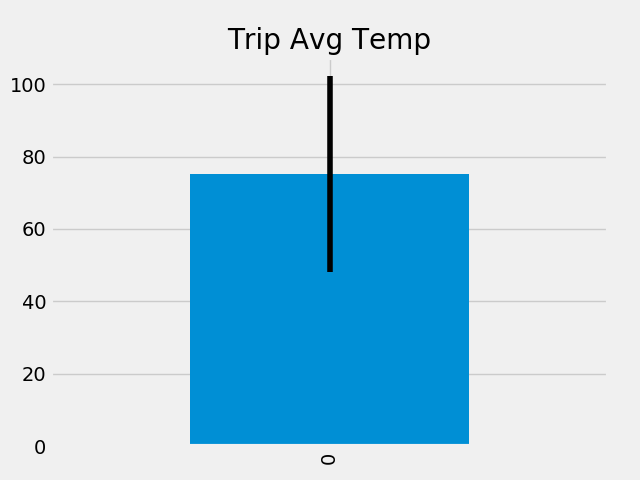

Text(0.5,1,'Trip Avg Temp')

In [165]:
# Plot the results from your previous query as a bar chart. 
fig=plt.figure()
df_stats = pd.DataFrame(stats, columns = ['station', 'min', 'max', 'avg'])
ax = df_stats['avg'].plot(kind='bar', yerr = df_stats['max'] - df_stats['min'])
plt.title('Trip Avg Temp')
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [184]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
sel = [Measurement.station,
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation,
      func.avg(Measurement.prcp)]
avg_rainfall = session.query(*sel).filter(Measurement.date > '2011-02-28').filter(Measurement.date < '2011-03-05')\
                                    .filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()
avg_rainfall
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.4875),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.425),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6,
  0.5825),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.4925),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.3275),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.29),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.245),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9,
  0.1575),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [ ]:
## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


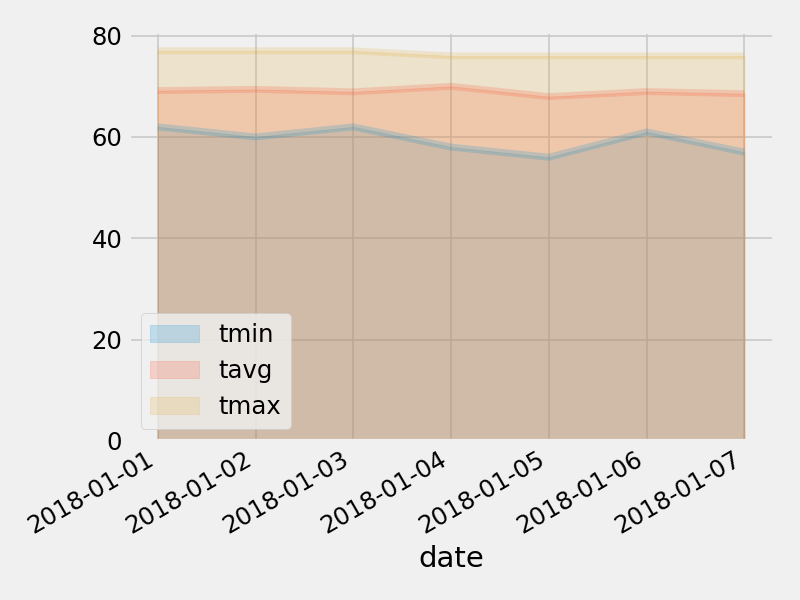

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
